 # Machine Fault Prediction
 

## Project details:

###  Given a Machine's sensor data values , we want to predict the values of the sensor three days into the future using Time Series Forecasting and check if there will be a fault in the machine in those three days. We also create a system that alerts the person incharge if and when the fault seems likely in the next three days. The fault will eventually lead to failure of the machine.Thus we are preventing the failure of a machine before it occurs.

### This Project is divided into the following sections

###  1) Data Visualization and Exploratory Analysis
###  2) Statistical Analysis
###  3) Forecasting using VAR,VARMA and LSTM with RNN
###  4) Final Prediction and Fault Detection

Let us start with importing modules

In [607]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow

# specific forecasting tools

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [608]:
df = pd.read_csv('C:\\Users\\Aditya\\Desktop\\projects in resume\\timeseriesjosh\\New folder\\machine_11.csv',index_col= 'date',
                infer_datetime_format=True)


In [609]:
df.index = pd.to_datetime(df.index)

In [610]:
df.head()

,0,1,2,3
date,,,,
2019-01-01 00:00:00,12.619190,8.822951,-11.786292,10.064528
2019-01-01 08:00:10,10.823407,2.797931,11.562981,21.887692
2019-01-01 16:00:19,21.094514,-0.644464,-17.826078,-1.360316
2019-02-01 00:00:29,32.296052,6.535904,-13.510324,-4.259116
2019-02-01 08:00:38,28.077653,3.687200,21.982494,13.636488


 We see that the data has four columns which is the sensor data and an index column which is the datetime index
 

 # Data Visualization and Exploratory Analysis

Consider sensor 0's data

<AxesSubplot:xlabel='date'>

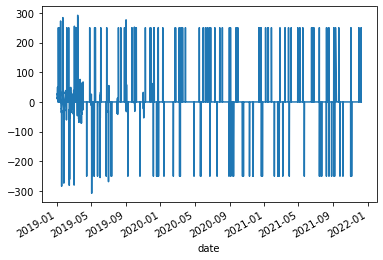

In [348]:
df['0'].plot()

We see that there are more fluctuations and variation in the year 2019. Lets zoom in on the first five months of january to geta better idea 

<AxesSubplot:xlabel='date'>

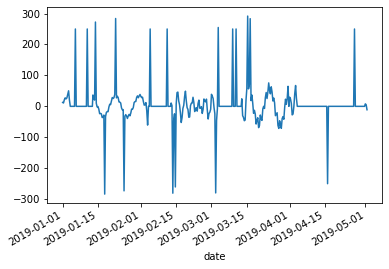

In [349]:
df['0']['2019-01-01':'2019-05-01'].plot()

we can see the fluctuations

Let's check for the other columns

<AxesSubplot:xlabel='date'>

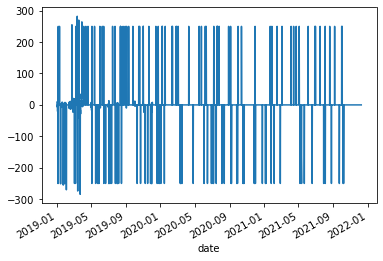

In [350]:
df['1'].plot()

<AxesSubplot:xlabel='date'>

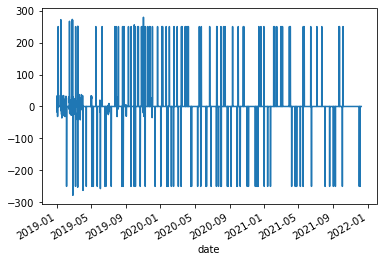

In [351]:
df['2'].plot()

<AxesSubplot:xlabel='date'>

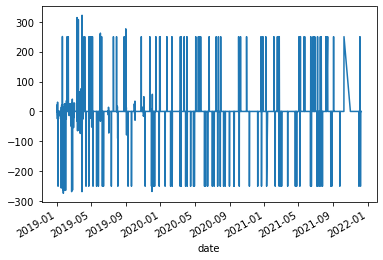

In [352]:
df['3'].plot()

There seems to be a similar patter for all the sensors.

Let's move into the distribution of the data to detect outliers

(array([  63.,    0.,    0.,    3.,   98., 2741.,   10.,    0.,    0.,
          85.]),
 array([-307.4498619 , -247.53316242, -187.61646294, -127.69976346,
         -67.78306398,   -7.8663645 ,   52.05033498,  111.96703446,
         171.88373394,  231.80043342,  291.7171329 ]),
 <BarContainer object of 10 artists>)

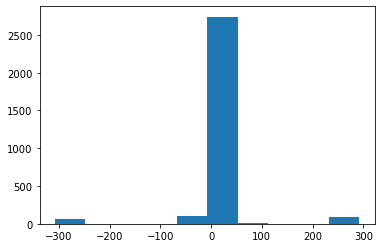

In [353]:
x=df['0']
plt.hist(x)


We see that for the sensor 0 the outliers are clearly separated.

Let's Zoom in to see which the points beyond which the outliers exist

(-80.0, 115.0)

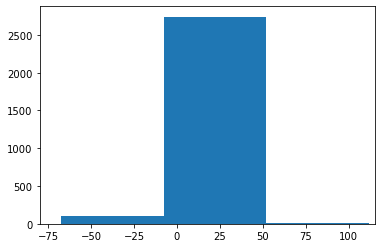

In [354]:
x=df['0']
plt.hist(x)
plt.xlim([-80,115])

We can see that anypoint beyond 110 and -68 on the other side is an outlier for sensor 0 

Similarly lets plot for sensors 1,2 and 3 and we find that the range is even smaller for these sensors

(-70.0, 70.0)

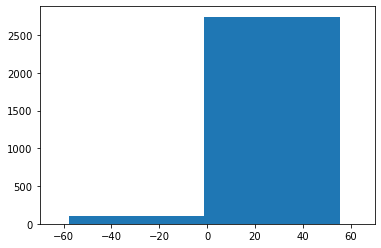

In [355]:
x=df['1']
plt.hist(x)
plt.xlim([-70,70])

We can see that anypoint beyond 55 and -55 on the other side is an outlier for sensor 1 

(-70.0, 70.0)

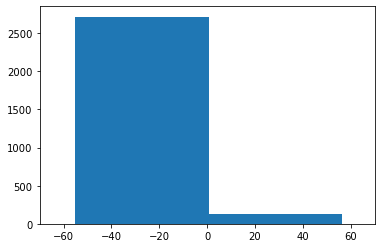

In [356]:
x=df['2']
plt.hist(x)
plt.xlim([-70,70])

We can see that anypoint beyond 55 and -55 on the other side is an outlier for sensor =2 

(-100.0, 100.0)

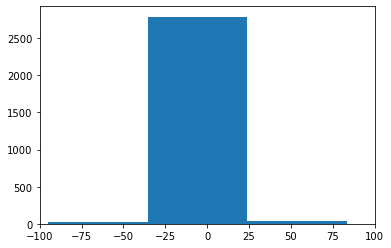

In [357]:
x=df['3']
plt.hist(x)
plt.xlim([-100,100])

We can see that anypoint beyond 80 and -95 on the other side is an outlier for sensor 3

We have detected our outliers

To process the outliers I have decided not to delete the outliers as that would delete a lot of values as we are considering for each sensor


Instead what i have decided to do is to cap the values at the range of non outliers for each sensor.

for example if we have a 231 value in our first sensor data column ( which is an outlier). The range of non outlier data for sensor 0 is -70 to 70. I will convert the value 231 to 70 in our data column. This ensures that we capture the actual implication of the reading as well as include the data point exists for further processing Thus ensuring that no vital information is lost.  

In [358]:
df['0']

date
2019-01-01 00:00:00     12.619190
2019-01-01 08:00:10     10.823407
2019-01-01 16:00:19     21.094514
2019-02-01 00:00:29     32.296052
2019-02-01 08:00:38     28.077653
                          ...    
2021-09-25 15:59:22   -250.014306
2021-09-25 23:59:31   -250.005644
2021-09-26 07:59:41     -0.007510
2021-09-26 15:59:50      0.000336
2021-09-27 00:00:00     -0.000462
Name: 0, Length: 3000, dtype: float64

In [359]:
# df1 is a duplicate of df for further processing
df1=df

Let's cap the values at the respective ranges

In [360]:
# capping sensor 0 
for i in range(len(df1)):
    if df1['0'][i] > 115:
        df1['0'][i]= 115
    elif df1['0'][i] < -80:
        df1['0'][i]= -80

        
#capping sensor 1
for i in range(len(df1)):
    if df1['1'][i] > 55:
        df1['1'][i]= 55
    elif df1['1'][i] < -55:
        df1['1'][i]= -55

#capping sensor 2
for i in range(len(df1)):
    if df1['2'][i] > 55:
        df1['2'][i]= 55
    elif df1['2'][i] < -55:
        df1['2'][i]= -55
        

#capping sensor 3
for i in range(len(df1)):
    if df1['3'][i] > 80:
        df1['3'][i]= 80
    elif df1['3'][i] < -95:
        df1['3'][i]= -95


In [361]:
#converting to positive values

for i in range(len(df1)):
    df1['0'][i]=df1['0'][i] + 81

for i in range(len(df1)):
    df1['1'][i]=df1['1'][i] + 56

for i in range(len(df1)):
    df1['2'][i]=df1['2'][i] + 56

for i in range(len(df1)):
    df1['3'][i]=df1['3'][i] + 96


# Statistical Analysis

Let's run some Statistical Analysis

We run a Dicky Fuller Test

In [362]:
from statsmodels.tsa.stattools import adfuller

In [363]:
adfuller(df1['0'])

(-18.532789128708444,
 2.1021188710106938e-30,
 14,
 2985,
 {'1%': -3.432542607157588,
  '5%': -2.8625087513967085,
  '10%': -2.5672856921402096},
 27194.14637258448)

I wrote a functions to make it more readable and to state what it means

In [364]:
df1test = adfuller(df1['0'])
df1out = pd.Series(df1test[0:4],index = ['ADF Test Statistic', 'p-value',' # lags Used','# Observations'])
df1out

ADF Test Statistic   -1.853279e+01
p-value               2.102119e-30
 # lags Used          1.400000e+01
# Observations        2.985000e+03
dtype: float64

In [365]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [366]:
adf_test(df['0'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.853279e+01
p-value                 2.102119e-30
# lags used             1.400000e+01
# observations          2.985000e+03
critical value (1%)    -3.432543e+00
critical value (5%)    -2.862509e+00
critical value (10%)   -2.567286e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We find that the sensor 0 column data is stationary

we perform the same test for other sensors

In [367]:
adf_test(df['1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.834835e+01
p-value                 2.239049e-30
# lags used             1.000000e+01
# observations          2.989000e+03
critical value (1%)    -3.432540e+00
critical value (5%)    -2.862507e+00
critical value (10%)   -2.567285e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [368]:
adf_test(df['2'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.187393e+01
p-value                 6.406933e-22
# lags used             2.700000e+01
# observations          2.972000e+03
critical value (1%)    -3.432552e+00
critical value (5%)    -2.862513e+00
critical value (10%)   -2.567288e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [369]:
adf_test(df['3'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.051046e+01
p-value                 1.027695e-18
# lags used             2.500000e+01
# observations          2.974000e+03
critical value (1%)    -3.432551e+00
critical value (5%)    -2.862512e+00
critical value (10%)   -2.567288e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We see that the data is stationary for all the sensors. 

Correalation Matrix

In [370]:
df1.corr()

,0,1,2,3
0,1.000000,-0.067853,-0.021766,-0.054830
1,-0.067853,1.000000,0.042843,0.020277
2,-0.021766,0.042843,1.000000,-0.019388
3,-0.054830,0.020277,-0.019388,1.000000


We see that there is no significant correlation between the predictor variables 

Let's check the causality

In [371]:
from statsmodels.tsa.stattools import grangercausalitytests

In [372]:
grangercausalitytests(df1[['0','1']],maxlag=12);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0098  , p=0.9213  , df_denom=2996, df_num=1
ssr based chi2 test:   chi2=0.0098  , p=0.9213  , df=1
likelihood ratio test: chi2=0.0098  , p=0.9213  , df=1
parameter F test:         F=0.0098  , p=0.9213  , df_denom=2996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2770  , p=0.7581  , df_denom=2993, df_num=2
ssr based chi2 test:   chi2=0.5549  , p=0.7577  , df=2
likelihood ratio test: chi2=0.5548  , p=0.7577  , df=2
parameter F test:         F=0.2770  , p=0.7581  , df_denom=2993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9859  , p=0.3983  , df_denom=2990, df_num=3
ssr based chi2 test:   chi2=2.9647  , p=0.3971  , df=3
likelihood ratio test: chi2=2.9633  , p=0.3973  , df=3
parameter F test:         F=0.9859  , p=0.3983  , df_denom=2990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0384  , p=0.

We see that for sensors 0 and 1. The granger causality test p value is minimum and it is below 0.05 so we can say that the seems to be some causality between sensors 0 and 1  after 9 data points and however we cannot simply conclude this fact.
If we shift the data by 9 points ( 3 days ) we might see some information.

Let's perform the same tests for the other sensors

On doing the same test with other sensors we found some causality between sensors 0 and 2 , sensors 0 and 3 and sensors 1 and 3

# Forecasting with VAR , VARMA and LSTM with RNN

Now lets get into forecasting

## VAR model

In [373]:
# Since we are predicting for the next 3 days 
# we have 3 observations in a day
# So totally 3*3 9 observations in 3 days 
# nob = 9

In [374]:
nob= 9 
train,test = df1[0:-nob],df1[-nob:]

In [375]:
print(train.shape)
print(test.shape)

(2991, 4)
(9, 4)


In [376]:
model = VAR(train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    results = model.fit(i)
    print('order =' ,i)
    print('AIC :', results.aic)
    print('BIC :', results.bic)
    print()

order = 1
AIC : 22.678000439790097
BIC : 22.718154477692334

order = 2
AIC : 22.660892444519913
BIC : 22.733189865009116

order = 3
AIC : 22.6483379266723
BIC : 22.75279666040896

order = 4
AIC : 22.643970297982666
BIC : 22.78060829183559

order = 5
AIC : 22.644403213907687
BIC : 22.813238430974106

order = 6
AIC : 22.649242290465747
BIC : 22.85029271009143

order = 7
AIC : 22.648165112181953
BIC : 22.881448729981397

order = 8
AIC : 22.649519019843662
BIC : 22.91505384772028

order = 9
AIC : 22.64105551693805
BIC : 22.9388595831044

order = 10
AIC : 22.63774802367994
BIC : 22.967839372677997

order = 11
AIC : 22.625048529369813
BIC : 22.987445222091257

order = 12
AIC : 22.61815028736271
BIC : 23.012870401069257

order = 13
AIC : 22.61996803726334
BIC : 23.047029665607102

order = 14
AIC : 22.618848881705308
BIC : 23.07827013474918

order = 15
AIC : 22.616065716939723
BIC : 23.107864721177805



In [377]:
model.endog_names

['0', '1', '2', '3']

The VAR(2) model seems to return the lowest combined scores
Just to verify that all the variables are included in the model we run
.endog_names.  We can see all the variables included

Fit the VAR(2) Model


In [378]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Nov, 2020
Time:                     20:46:12
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    22.7332
Nobs:                     2989.00    HQIC:                   22.6869
Log likelihood:          -50795.5    FPE:                6.94226e+09
AIC:                      22.6609    Det(Omega_mle):     6.85927e+09
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        72.447052         5.111137           14.174           0.000
L1.0          0.143848         0.018286            7.866           0.000
L1.1          0.017955         0.034301            0.523           0.601
L1.2         -0.121169 

In [379]:
lag_order = results.k_ar
lag_order

2

In [380]:
z = results.forecast(y =train.values[-lag_order:],steps = 9)
z

array([[76.56308457, 55.06528746, 60.89797797, 91.93740772],
       [78.20401542, 57.44872524, 55.9134221 , 92.79073513],
       [81.2713738 , 56.20166223, 56.10651472, 95.37782961],
       [82.01608354, 56.06707332, 56.08211572, 95.607865  ],
       [82.48017712, 55.99254789, 56.19237532, 95.35227415],
       [82.61620013, 55.96130653, 56.22341326, 95.31211722],
       [82.66391279, 55.93539653, 56.23785965, 95.31101116],
       [82.67897431, 55.92745543, 56.24175589, 95.30821557],
       [82.68461893, 55.92453854, 56.24337054, 95.30577077]])

In [381]:
# add the values to the dataframe df_forecast
idx=pd.date_range('2021-09-24 07:58:43',periods = 9,freq ='28809S')
df_forecast = pd.DataFrame(z, index = idx , columns = ['0T','1T','2T','3T'])


df_forecast

,0T,1T,2T,3T
2021-09-24 07:58:43,76.563085,55.065287,60.897978,91.937408
2021-09-24 15:58:52,78.204015,57.448725,55.913422,92.790735
2021-09-24 23:59:01,81.271374,56.201662,56.106515,95.377830
2021-09-25 07:59:10,82.016084,56.067073,56.082116,95.607865
2021-09-25 15:59:19,82.480177,55.992548,56.192375,95.352274
2021-09-25 23:59:28,82.616200,55.961307,56.223413,95.312117
2021-09-26 07:59:37,82.663913,55.935397,56.237860,95.311011
2021-09-26 15:59:46,82.678974,55.927455,56.241756,95.308216
2021-09-26 23:59:55,82.684619,55.924539,56.243371,95.305771


We use Rmse error to evaluate the model performance

In [382]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['0'],df_forecast['0T'])
print('Rmse for sensor 0 is :',error,'The mean test values of sensor 0 is :',test['0'].mean())
error = rmse(test['1'],df_forecast['1T'])
print('Rmse for sensor 1 is :',error,'The mean test values of sensor 1 is :',test['1'].mean())
error = rmse(test['2'],df_forecast['2T'])
print('Rmse for sensor 2 is :',error,'The mean test values of sensor 2 is :',test['2'].mean())
error = rmse(test['3'],df_forecast['3T'])
print('Rmse for sensor 3 is :',error,'The mean test values of sensor 3 is :',test['3'].mean())

Rmse for sensor 0 is : 38.49568339389723 The mean test values of sensor 0 is : 63.21870698711112
Rmse for sensor 1 is : 0.5746793882400698 The mean test values of sensor 1 is : 56.00040807911111
Rmse for sensor 2 is : 1.6432441219958358 The mean test values of sensor 2 is : 56.002081082
Rmse for sensor 3 is : 31.5880670321061 The mean test values of sensor 3 is : 85.45247606433333


We see that the RMSE is less than the mean values of the test data for each column. So our prediction is good.

<AxesSubplot:xlabel='date'>

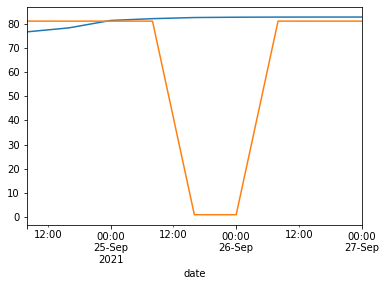

In [383]:
df_forecast['0T'].plot()
test['0'].plot()

<AxesSubplot:xlabel='date'>

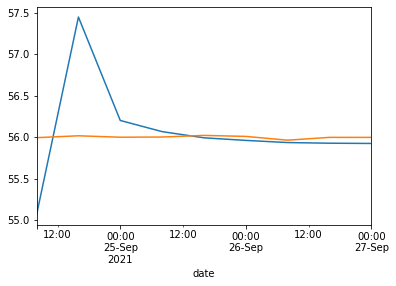

In [384]:
df_forecast['1T'].plot()
test['1'].plot()

<AxesSubplot:xlabel='date'>

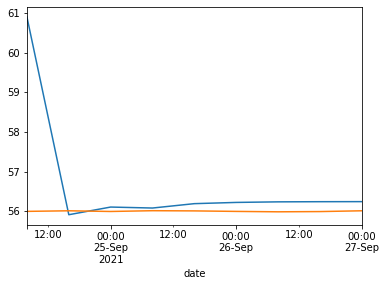

In [385]:
df_forecast['2T'].plot()
test['2'].plot()

<AxesSubplot:xlabel='date'>

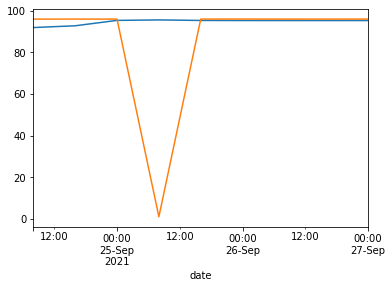

In [386]:
df_forecast['3T'].plot()
test['3'].plot()

#  VARMA model

In [387]:
df1=df

In [388]:
# capping sensor 0 
for i in range(len(df1)):
    if df1['0'][i] > 115:
        df1['0'][i]= 115
    elif df1['0'][i] < -80:
        df1['0'][i]= -80

        
#capping sensor 1
for i in range(len(df1)):
    if df1['1'][i] > 55:
        df1['1'][i]= 55
    elif df1['1'][i] < -55:
        df1['1'][i]= -55

#capping sensor 2
for i in range(len(df1)):
    if df1['2'][i] > 55:
        df1['2'][i]= 55
    elif df1['2'][i] < -55:
        df1['2'][i]= -55
        

#capping sensor 3
for i in range(len(df1)):
    if df1['3'][i] > 80:
        df1['3'][i]= 80
    elif df1['3'][i] < -95:
        df1['3'][i]= -95


In [389]:
#converting to positive values

for i in range(len(df1)):
    df1['0'][i]=df1['0'][i] + 81

for i in range(len(df1)):
    df1['1'][i]=df1['1'][i] + 56

for i in range(len(df1)):
    df1['2'][i]=df1['2'][i] + 56

for i in range(len(df1)):
    df1['3'][i]=df1['3'][i] + 96


In [390]:
#split into train test
nob= 9 
train,test = df1[0:-nob],df1[-nob:]

In [391]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['0', '1', '2', '3']",No. Observations:,2991
Model:,"VARMA(1,2)",Log Likelihood,-45465.987
,+ intercept,AIC,91055.973
Date:,"Wed, 18 Nov 2020",BIC,91428.182
Time:,20:48:22,HQIC,91189.876
Sample:,0,,
,- 2991,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.11, 0.07, 0.02, 0.02",Jarque-Bera (JB):,"40969.10, 128131.30, 111516.03, 123870.50"
Prob(Q):,"0.74, 0.78, 0.88, 0.90",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.73, 0.67, 0.63, 0.81",Skew:,"-3.01, -5.54, -5.26, -5.54"


In [392]:
df_forecast_1 = results.forecast(9)
idx=pd.date_range('2021-09-24 07:58:43',periods = 9,freq ='28809S')
df_forecast_1 =df_forecast.set_index(idx)
df_forecast_1.columns = ['0T','1T','2T','3T']
df_forecast_1


,0T,1T,2T,3T
2021-09-24 07:58:43,76.563085,55.065287,60.897978,91.937408
2021-09-24 15:58:52,78.204015,57.448725,55.913422,92.790735
2021-09-24 23:59:01,81.271374,56.201662,56.106515,95.377830
2021-09-25 07:59:10,82.016084,56.067073,56.082116,95.607865
2021-09-25 15:59:19,82.480177,55.992548,56.192375,95.352274
2021-09-25 23:59:28,82.616200,55.961307,56.223413,95.312117
2021-09-26 07:59:37,82.663913,55.935397,56.237860,95.311011
2021-09-26 15:59:46,82.678974,55.927455,56.241756,95.308216
2021-09-26 23:59:55,82.684619,55.924539,56.243371,95.305771


In [393]:
test

,0,1,2,3
date,,,,
2021-09-24 07:58:43,162.002082,111.0,111.0,176.0
2021-09-24 15:58:53,161.988650,111.0,111.0,176.0
2021-09-24 23:59:02,161.992876,111.0,111.0,176.0
2021-09-25 07:59:12,161.992391,111.0,111.0,97.0
2021-09-25 15:59:22,82.000000,111.0,111.0,176.0
2021-09-25 23:59:31,82.000000,111.0,111.0,176.0
2021-09-26 07:59:41,161.992490,111.0,111.0,176.0
2021-09-26 15:59:50,162.000336,111.0,111.0,176.0
2021-09-27 00:00:00,161.999538,111.0,111.0,176.0


In [394]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['0'],df_forecast_1['0T'])
print('Rmse for sensor 0 is :',error,'The mean test values of sensor 0 is :',test['0'].mean())
error = rmse(test['1'],df_forecast_1['1T'])
print('Rmse for sensor 1 is :',error,'The mean test values of sensor 1 is :',test['1'].mean())
error = rmse(test['2'],df_forecast_1['2T'])
print('Rmse for sensor 2 is :',error,'The mean test values of sensor 2 is :',test['2'].mean())
error = rmse(test['3'],df_forecast_1['3T'])
print('Rmse for sensor 3 is :',error,'The mean test values of sensor 3 is :',test['3'].mean())

Rmse for sensor 0 is : 71.57608707554692 The mean test values of sensor 0 is : 144.21870698711112
Rmse for sensor 1 is : 54.944815844548124 The mean test values of sensor 1 is : 111.0
Rmse for sensor 2 is : 54.338454132242944 The mean test values of sensor 2 is : 111.0
Rmse for sensor 3 is : 76.76819315118954 The mean test values of sensor 3 is : 167.22222222222223


# LSTM with RNN Model


In [611]:
#creating a copy of the original dataframe as df1
df1=df

In [612]:
# capping sensor 0 
for i in range(len(df1)):
    if df1['0'][i] > 115:
        df1['0'][i]= 115
    elif df1['0'][i] < -80:
        df1['0'][i]= -80

        
#capping sensor 1
for i in range(len(df1)):
    if df1['1'][i] > 55:
        df1['1'][i]= 55
    elif df1['1'][i] < -55:
        df1['1'][i]= -55

#capping sensor 2
for i in range(len(df1)):
    if df1['2'][i] > 55:
        df1['2'][i]= 55
    elif df1['2'][i] < -55:
        df1['2'][i]= -55
        

#capping sensor 3
for i in range(len(df1)):
    if df1['3'][i] > 80:
        df1['3'][i]= 80
    elif df1['3'][i] < -95:
        df1['3'][i]= -95


In [613]:
#converting to positive values

for i in range(len(df1)):
    df1['0'][i]=df1['0'][i] + 81

for i in range(len(df1)):
    df1['1'][i]=df1['1'][i] + 56

for i in range(len(df1)):
    df1['2'][i]=df1['2'][i] + 56

for i in range(len(df1)):
    df1['3'][i]=df1['3'][i] + 96


In [614]:
test_days=3
test_ind = 9

In [615]:
train = df1.iloc[:-test_ind]
test = df1.iloc[-test_ind:]

In [616]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [617]:
# We use MinMaxScaler to scale our data. This gives us a more accurate prediction
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [618]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [619]:
length = 3
batch_size = 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length = length, batch_size = batch_size)

In [620]:
len(scaled_train)

2991

In [621]:
len(generator)

2988

In [622]:
X,y = generator[0]

In [623]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.47497021 0.58020864 0.39285189 0.60036873 0.46576106 0.52543574
 0.60511801 0.66792967 0.51843341 0.49414124 0.33794474 0.53508391]
Predict this y: 
 [[0.57587719 0.55941731 0.37717887 0.51851934]]


In [624]:
scaled_train.shape

(2991, 4)

In [625]:
# model
model = Sequential()

# RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [626]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 404       
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________


In [627]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [628]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2988 steps, validate for 6 steps
Epoch 1/10
2988/2988 [==============================] - 7s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 2/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0150 - val_loss: 0.0251
Epoch 3/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0148 - val_loss: 0.0249
Epoch 4/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0147 - val_loss: 0.0281
Epoch 5/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0146 - val_loss: 0.0253
Epoch 6/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0265
Epoch 7/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0267
Epoch 8/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0235
Epoch 9/10
2988/2988 [==============================] - 6s 2ms/step - loss: 0.0145 - val_lo

In [629]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<AxesSubplot:>

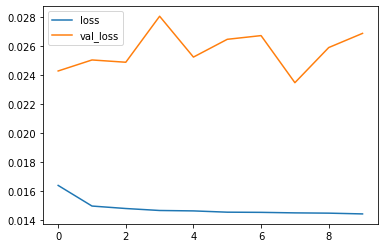

In [630]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [631]:
first_eval_batch = scaled_train[-length:]

In [632]:
first_eval_batch

array([[0.41032909, 0.        , 0.50005778, 0.54280313],
       [0.41024942, 0.        , 0.49996634, 0.54286193],
       [0.41026027, 0.49993634, 1.        , 0.54289371]])

In [633]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [634]:
model.predict(first_eval_batch)

array([[0.42390907, 0.49537995, 0.5092985 , 0.5413092 ]], dtype=float32)

In [635]:
scaled_test[0]

array([0.41026709, 0.49994847, 0.49997927, 0.54281603])

In [636]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [637]:
test_predictions

[array([0.42390907, 0.49537995, 0.5092985 , 0.5413092 ], dtype=float32),
 array([0.4238382 , 0.50132895, 0.477274  , 0.5443471 ], dtype=float32),
 array([0.43247467, 0.52069724, 0.48415303, 0.560948  ], dtype=float32),
 array([0.44047475, 0.5047542 , 0.48258632, 0.5507803 ], dtype=float32),
 array([0.4424864 , 0.5032335 , 0.4818583 , 0.54963386], dtype=float32),
 array([0.44396698, 0.50285304, 0.48279893, 0.55041474], dtype=float32),
 array([0.44443023, 0.5016261 , 0.48266917, 0.54957783], dtype=float32),
 array([0.44465876, 0.5013427 , 0.48264778, 0.54938316], dtype=float32),
 array([0.44479322, 0.5012236 , 0.482706  , 0.5493835 ], dtype=float32)]

In [638]:
scaled_test

array([[0.41026709, 0.49994847, 0.49997927, 0.54281603],
       [0.4101982 , 0.50015448, 0.50011309, 0.54289765],
       [0.41021987, 0.4999973 , 0.49995624, 0.54288378],
       [0.41021739, 0.50001767, 0.5001329 , 0.        ],
       [0.        , 0.50019679, 0.5000889 , 0.54294758],
       [0.        , 0.50008627, 0.49997226, 0.54301908],
       [0.4102179 , 0.49967262, 0.49987971, 0.54286789],
       [0.41025814, 0.49998129, 0.49993368, 0.54286698],
       [0.41025404, 0.4999785 , 0.50011422, 0.5429712 ]])

In [639]:
true_predictions = scaler.inverse_transform(test_predictions)
descaled_test    = scaler.inverse_transform(scaled_test)

In [640]:
# create a dataframe called df_forecast_2 to store the predicted values
idx=pd.date_range('2021-09-24 07:58:43',periods = 9,freq ='28809S')
df_forecast_2 = pd.DataFrame(true_predictions, index = idx , columns = ['0T','1T','2T','3T'])

In [641]:
#scaled test df to compare as scaled_test_compare

idx=pd.date_range('2021-09-24 07:58:43',periods = 9,freq ='28809S')
scaled_test_compare = pd.DataFrame(descaled_test, index = idx , columns = ['0','1','2','3'])

In [642]:
from statsmodels.tools.eval_measures import rmse
error = rmse(scaled_test_compare['0'],df_forecast_2['0T'])
print('Rmse for sensor 0 is :',error,'The mean test values of sensor 0 is :',scaled_test_compare['0'].mean())
error = rmse(scaled_test_compare['1'],df_forecast_2['1T'])
print('Rmse for sensor 1 is :',error,'The mean test values of sensor 1 is :',scaled_test_compare['1'].mean())
error = rmse(scaled_test_compare['2'],df_forecast_2['2T'])
print('Rmse for sensor 2 is :',error,'The mean test values of sensor 2 is :',scaled_test_compare['2'].mean())
error = rmse(scaled_test_compare['3'],df_forecast_2['3T'])
print('Rmse for sensor 3 is :',error,'The mean test values of sensor 3 is :',scaled_test_compare['3'].mean())

Rmse for sensor 0 is : 41.01858880649659 The mean test values of sensor 0 is : 63.21870698711112
Rmse for sensor 1 is : 0.8176492595578422 The mean test values of sensor 1 is : 56.00040807911111
Rmse for sensor 2 is : 1.902227709510153 The mean test values of sensor 2 is : 56.002081082
Rmse for sensor 3 is : 32.15842263387756 The mean test values of sensor 3 is : 85.45247606433333


<AxesSubplot:>

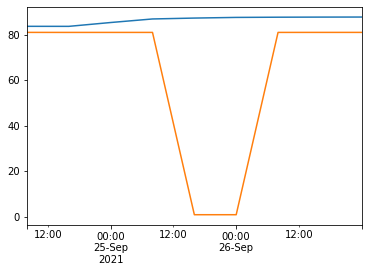

In [643]:
df_forecast_2['0T'].plot()
scaled_test_compare['0'].plot()

<AxesSubplot:>

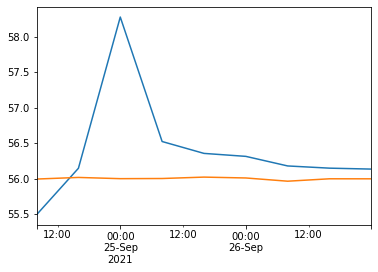

In [644]:
df_forecast_2['1T'].plot()
scaled_test_compare['1'].plot()

<AxesSubplot:>

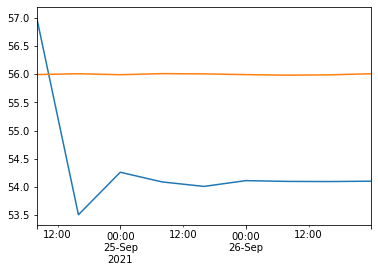

In [645]:
df_forecast_2['2T'].plot()
scaled_test_compare['2'].plot()

<AxesSubplot:>

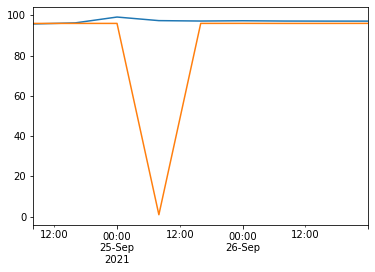

In [646]:
df_forecast_2['3T'].plot()
scaled_test_compare['3'].plot()

## We find that among the models implemented. The LSTM with RNN model performs the best.


### Hence we use it for predicting future values and alerting us of a fault in the machine

# Final Prediction and Fault Detection

In [581]:
df_final = df

In [582]:
# capping sensor 0 
for i in range(len(df_final)):
    if df_final['0'][i] > 115:
        df_final['0'][i]= 115
    elif df_final['0'][i] < -80:
        df_final['0'][i]= -80

        
#capping sensor 1
for i in range(len(df_final)):
    if df_final['1'][i] > 55:
        df_final['1'][i]= 55
    elif df_final['1'][i] < -55:
        df_final['1'][i]= -55

#capping sensor 2
for i in range(len(df_final)):
    if df_final['2'][i] > 55:
        df_final['2'][i]= 55
    elif df_final['2'][i] < -55:
        df_final['2'][i]= -55
        

#capping sensor 3
for i in range(len(df_final)):
    if df_final['3'][i] > 80:
        df_final['3'][i]= 80
    elif df_final['3'][i] < -95:
        df_final['3'][i]= -95


In [583]:
#converting to positive values

for i in range(len(df_final)):
    df_final['0'][i]=df_final['0'][i] + 81

for i in range(len(df1)):
    df_final['1'][i]=df_final['1'][i] + 56

for i in range(len(df1)):
    df_final['2'][i]=df_final['2'][i] + 56

for i in range(len(df1)):
    df_final['3'][i]=df_final['3'][i] + 96


### We train the data on the entire dataset to predict the future values

In [584]:
train = df_final

In [585]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [586]:
scaled_train = scaler.transform(train)
# let's take 10 % of the data for validation that is 300 rows
val_gen =scaler.transform(train[-300:]) 

In [587]:
length = 3
batch_size = 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length = length, batch_size = batch_size)

In [588]:
X,y = generator[0]

In [589]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.47497021 0.58020864 0.39285189 0.60036873 0.46576106 0.52543574
 0.60511801 0.66792967 0.51843341 0.49414124 0.33794474 0.53508391]
Predict this y: 
 [[0.57587719 0.55941731 0.37717887 0.51851934]]


In [590]:
scaled_train.shape

(3000, 4)

In [591]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [592]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 404       
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________


In [593]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(val_gen,val_gen, 
                                           length=length, batch_size=batch_size)

In [594]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2997 steps, validate for 297 steps
Epoch 1/10
2997/2997 [==============================] - 8s 3ms/step - loss: 0.0163 - val_loss: 0.0143
Epoch 2/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 3/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 4/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 5/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 6/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 7/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 8/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 9/10
2997/2997 [==============================] - 6s 2ms/step - loss: 0.0145 - val_

In [595]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<AxesSubplot:>

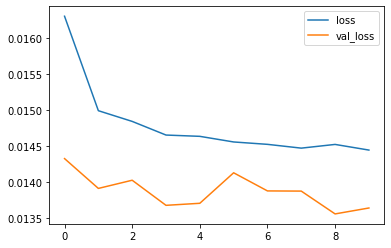

In [596]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [597]:
n_features = scaled_train.shape[1]
final_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(9):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    final_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [598]:
final_predictions = scaler.inverse_transform(final_predictions)

In [599]:
final_predictions

array([[79.15239489, 54.09124231, 55.53977227, 94.34499985],
       [78.96807304, 54.02889317, 55.48020637, 94.2700336 ],
       [78.87300929, 53.97848672, 55.41188753, 94.17845106],
       [78.83167243, 53.94554025, 55.38301921, 94.13047975],
       [78.82400131, 53.94195384, 55.37683642, 94.12424213],
       [78.82038659, 53.9386887 , 55.3737942 , 94.11964214],
       [78.81916618, 53.93729544, 55.37268615, 94.11781675],
       [78.8189221 , 53.9369545 , 55.37240422, 94.11739951],
       [78.8188175 , 53.93676436, 55.37229276, 94.11717004]])

In [600]:
# create a dataframe df_forecast_final to store all the predicted values and respective index
idx=pd.date_range('2021-09-27 00:00:00',periods = 9,freq ='28809S')
df_forecast_final = pd.DataFrame(final_predictions, index = idx , columns = ['0T','1T','2T','3T'])

In [601]:
df_forecast_final

,0T,1T,2T,3T
2021-09-27 00:00:00,79.152395,54.091242,55.539772,94.345000
2021-09-27 08:00:09,78.968073,54.028893,55.480206,94.270034
2021-09-27 16:00:18,78.873009,53.978487,55.411888,94.178451
2021-09-28 00:00:27,78.831672,53.945540,55.383019,94.130480
2021-09-28 08:00:36,78.824001,53.941954,55.376836,94.124242
2021-09-28 16:00:45,78.820387,53.938689,55.373794,94.119642
2021-09-29 00:00:54,78.819166,53.937295,55.372686,94.117817
2021-09-29 08:01:03,78.818922,53.936954,55.372404,94.117400
2021-09-29 16:01:12,78.818817,53.936764,55.372293,94.117170


In [602]:
# undo the convert to positive values

for i in range(len(df_forecast_final)):
    df_forecast_final['0T'][i]=df_forecast_final['0T'][i] - 81

for i in range(len(df_forecast_final)):
    df_forecast_final['1T'][i]=df_forecast_final['1T'][i] - 56

for i in range(len(df_forecast_final)):
    df_forecast_final['2T'][i]=df_forecast_final['2T'][i] - 56

for i in range(len(df_forecast_final)):
    df_forecast_final['3T'][i]=df_forecast_final['3T'][i] - 96


In [603]:
df_forecast_final

,0T,1T,2T,3T
2021-09-27 00:00:00,-1.847605,-1.908758,-0.460228,-1.655000
2021-09-27 08:00:09,-2.031927,-1.971107,-0.519794,-1.729966
2021-09-27 16:00:18,-2.126991,-2.021513,-0.588112,-1.821549
2021-09-28 00:00:27,-2.168328,-2.054460,-0.616981,-1.869520
2021-09-28 08:00:36,-2.175999,-2.058046,-0.623164,-1.875758
2021-09-28 16:00:45,-2.179613,-2.061311,-0.626206,-1.880358
2021-09-29 00:00:54,-2.180834,-2.062705,-0.627314,-1.882183
2021-09-29 08:01:03,-2.181078,-2.063046,-0.627596,-1.882600
2021-09-29 16:01:12,-2.181183,-2.063236,-0.627707,-1.882830


In [604]:
# store the predicted values in the final dataframe 
df_forecast_final.index = pd.to_datetime(df_forecast_final.index)
final=pd.DataFrame(df_forecast_final.index.values)

### We Assume the Faulty threshold to be -0.6 to 0.6 (This completely depends on the company and requirements)

In [606]:
df_f = df_forecast_final
for i in range(len(df_f)):
    if df_f['0T'][i]==0 and df_f['1T'][i]==0 and df_f['2T'][i]==0 and df_f['3T'][i]==0 :
        print('Machine Failed')
    elif  df_f['0T'][i]<0.07 and df_f['0T'][i]>-0.6 or df_f['1T'][i]<0.6 and df_f['1T'][i]>-0.6 or df_f['2T'][i]<0.6 and df_f['2T'][i]>-0.6 or df_f['3T'][i]<0.6 and df_f['3T'][i]>-0.6 :
        print("Fault detected at",str(final[0][i]))

Fault detected at 2021-09-27 00:00:00
Fault detected at 2021-09-27 08:00:09
Fault detected at 2021-09-27 16:00:18


### We predicted the sensor values 3 days into the future and tried detecting faults with the values
### We see that the faults are detected at the timings above.
### This will be reported to the person incharge or management so that they can take the neccessary action.